In [73]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

'\nfor i in (2, 6, 10, 14):\n    plot(f"eval_${i}.weight.l2")\nfor i in (2, 6, 10, 14):\n    plot(f"eval_${i}.bias.l2")'

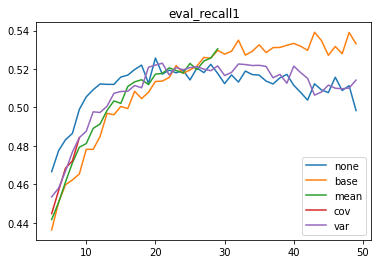

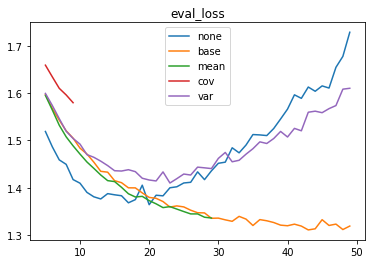

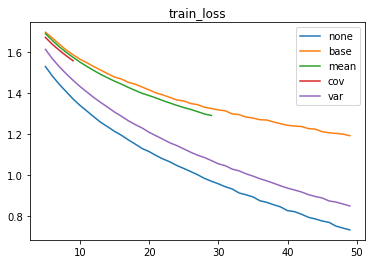

In [86]:
df_map = {}
for tag in ("none", "base", "mean", "cov", "var"):
    try:
        df_map[tag] = pd.read_json(f"outputs/{tag}_1/logs.json")
    except:
        pass

def plot(key, start=5):
    _, ax = plt.subplots(1, 1)
    ax.set_title(key)
    for tag, df in df_map.items():
        df[df.index >= start][key].plot(ax=ax, label=tag)
    ax.legend()

plot(f"eval_recall1")
plot(f"eval_loss")
plot(f"train_loss")
'''
for i in (2, 6, 10, 14):
    plot(f"eval_${i}.weight.l2")
for i in (2, 6, 10, 14):
    plot(f"eval_${i}.bias.l2")'''

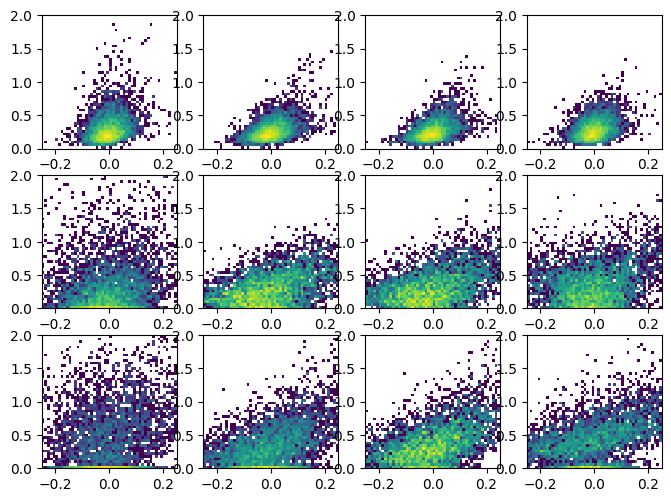

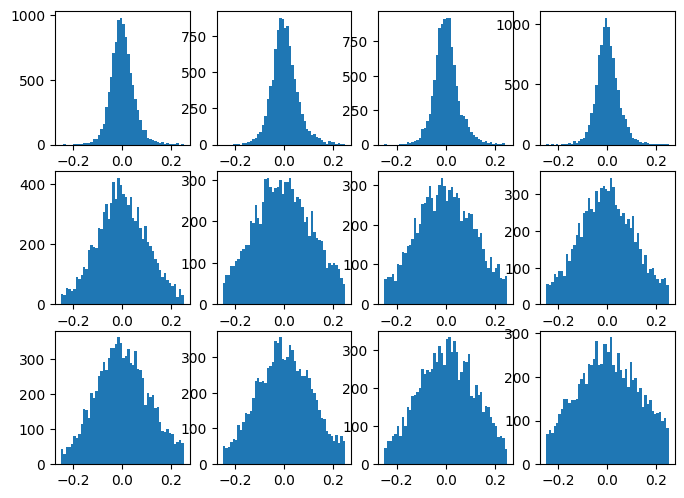

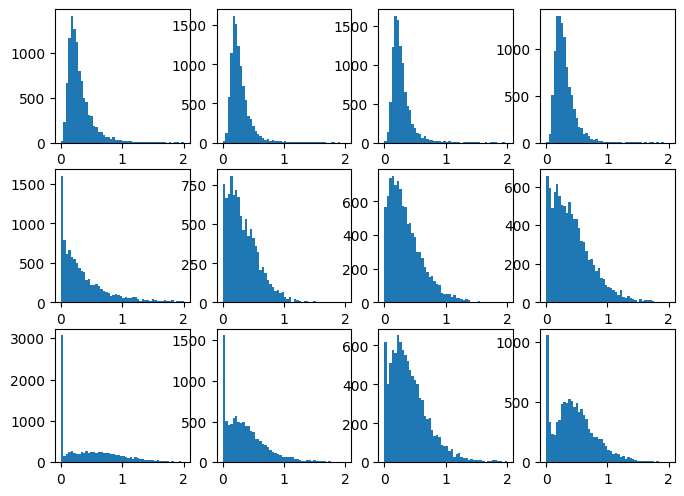

In [92]:
def outer(x):
    return x.unsqueeze(-1) * x.unsqueeze(-2)

def corr(m1, m2):
    #sd = (m2.diagonal() - m1.square() + 1e-6).sqrt()
    #corr = (m2 - outer(m1)) / outer(sd)
    corr = m2 / m2.diagonal().mean()
    return corr.flatten().numpy()

def read_state(state, i):
    num = state[f"{i}.num"]
    sum = state[f"{i}.sum"]
    sum_sq = state[f"{i}.sum_sq"]
    return corr(sum / num, sum_sq / num)

def read_weight(state, i, fwd):
    w = state[f"{i}.weight"]
    if not fwd:
        w = w.T
    return corr(w.mean(1), w @ w.T)

tags = ("none", "base", "mean", "var")
epochs = (50,)
xrange = (-.25, .25)
yrange = (0, 2)

for epoch in epochs:
    _, ax_xy = plt.subplots(3, len(tags), dpi=100, figsize=(8, 6))
    _, ax_x = plt.subplots(3, len(tags), dpi=100, figsize=(8, 6))
    _, ax_y = plt.subplots(3, len(tags), dpi=100, figsize=(8, 6))
    for i, tag in enumerate(tags):
        state = torch.load(f"outputs/{tag}_1/checkpoint-20.pt")
        for j in range(3):
            x = read_weight(state["model"], j*4+2, True)
            #x = read_weight(state["model"], i*4+6, False)
            y = read_state(state["model"], j*4+4)
            ax_xy[j][i].hist2d(
                x, y, bins=(50, 50), 
                range=(xrange, yrange), 
                norm=mpl.colors.LogNorm())
            ax_x[j][i].hist(x, bins=50, range=xrange)
            ax_y[j][i].hist(y, bins=50, range=yrange)